## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.14.0               |   py37h89c1867_0        1010 KB  conda-forge
    toolz-0.12.1               |     pyhd8ed1ab_0          51 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.0 MB

The following NEW packages will be INSTALLED:

  toolz              conda-forge/noarch::toolz-0.12.1-pyhd8ed1ab_0

The following packages will be UPDATED:

  conda                               4.12.0-py37h89c1867_0 --> 4.14.0-py37h89c1867_0



conda-4.14.0         | 1010 KB   | ##################################### | 100% 
toolz-0.12.1         | 51 KB     | ##################################### | 100% 
Preparing transaction: done
Ver

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(1):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:55<00:00,  3.38it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_0"])
layer_hs_array.shape

(10000, 267264)

## Layer 0 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

dim_reduced_vecs = layer_hs_array

# random_projector = GaussianRandomProjection(random_state = 42)
# dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 267264)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
# X_train, y_train, X_test, y_test = [], [], [], []
# for i in range(10):
#     X_train.extend(dim_reduced_vecs[i * 1000 : (i * 1000) + 800]) # [0:800] [1000:1800] etc.
#     y_train.extend(prompt_ids[i * 1000 : (i * 1000) + 800])
    
#     X_test.extend(dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]) # [800:1000] [1800:2000] etc.
#     y_test.extend(prompt_ids[(i * 1000) + 800 : (i + 1) * 1000])

In [11]:
# X_train = np.array(X_train)
# y_train = np.array(y_train)
# X_test = np.array(X_test)
# y_test = np.array(y_test)

# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

In [12]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [13]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 267264)
(8000,)
(2000, 267264)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 267264D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 3.66 s
Outer iteration 0 / 10
  Iteration 19 (10.99 s, search 7.38 s): objective=1142.97 imbalance=1.532 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (21.99 s, search 14.75 s): objective=1146.89 imbalance=1.203 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (32.99 s, search 22.13 s): objective=1139.01 imbalance=1.048 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (44.00 s, search 29.51 s): objective=1141.68 imbalance=1.141 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (54.99 s, search 36.86 s): objective=1148.22 imbalance=1.544 nsplit=0       
Objective improved: keep new clusters
Outer iteration 5 / 10
  Iteration 19 (65.97 s, search 44.22 s): objective=1147.13 imbalance=1.696 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (76.97 s,

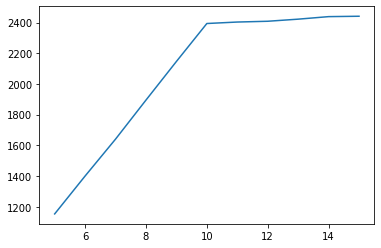

In [15]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

#k_vals[np.argmax(wccs)]

In [16]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 267264D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 1.12 s
Outer iteration 0 / 10
  Iteration 19 (22.05 s, search 14.76 s): objective=2372.75 imbalance=1.205 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (44.12 s, search 29.52 s): objective=2393.49 imbalance=1.647 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (66.16 s, search 44.27 s): objective=2391.65 imbalance=1.230 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (88.24 s, search 59.05 s): objective=2382.37 imbalance=1.366 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (110.29 s, search 73.78 s): objective=2345.79 imbalance=1.845 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (132.34 s, search 88.53 s): objective=2368.57 imbalance=1.255 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (154.41 s, search 103.29 s): objective=2367.41 imbalance=1.285 nsplit=0       
Outer ite

2393.4873046875

In [17]:
kmeans.centroids #cluster centers

array([[-7.2434093e-03, -4.5633418e-03,  1.4185005e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-8.9947749e-03, -5.6667142e-03,  1.7614776e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-9.4632590e-03, -5.9618461e-03,  1.8532209e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-8.1078485e-03, -5.1079481e-03,  1.5877873e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-6.3845143e-03, -4.0222472e-03,  1.2503022e-04, ...,
         5.1265738e-06, -2.1565485e-05, -2.1605617e-06],
       [-7.9250773e-03, -4.9928031e-03,  1.5519944e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [18]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.0000256
1.0000032
1.0000032
1.0000665
1.0000328
1.0000358
1.0000036
1.000024
1.0000113
1.0000374


In [19]:
kmeans.obj #inertia at each iteration

array([ 756.99981689, 2284.49804688, 2345.12915039, 2357.94555664,
       2363.91967773, 2367.46411133, 2368.86547852, 2369.89599609,
       2370.89648438, 2372.14868164, 2372.39624023, 2372.53100586,
       2372.62426758, 2372.67114258, 2372.71411133, 2372.73193359,
       2372.7409668 , 2372.74926758, 2372.75024414, 2372.75024414,
        799.1272583 , 2261.57861328, 2341.63574219, 2358.4284668 ,
       2368.30273438, 2374.22949219, 2376.82592773, 2380.03540039,
       2385.21166992, 2387.21704102, 2388.78613281, 2390.0390625 ,
       2391.08398438, 2392.04418945, 2392.75048828, 2393.14819336,
       2393.32714844, 2393.42456055, 2393.47241211, 2393.48730469])

In [20]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [21]:
pd.Series(classifications_train).value_counts()

8    2605
0    1140
4     719
2     690
6     672
5     622
9     501
1     440
3     330
7     281
dtype: int64

In [22]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[6, 2, 8, 4, 5, 3, 6, 9, 1, 10]

In [23]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [24]:
centroid_to_label

{0: 6, 1: 2, 2: 8, 3: 4, 4: 5, 5: 3, 6: 6, 7: 9, 8: 1, 9: 10}

In [25]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 6,  6,  9, ..., 10, 10,  1])

In [26]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.38375
Prompt 2 Accuracy:  0.24625
Prompt 3 Accuracy:  0.7775
Prompt 4 Accuracy:  0.16875
Prompt 5 Accuracy:  0.58125
Prompt 6 Accuracy:  0.50875
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.26
Prompt 9 Accuracy:  0.1875
Prompt 10 Accuracy:  0.62625


In [27]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.374


## Perform Inference on Test Set & Collect Test Accuracy

In [28]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [29]:
pd.Series(classifications_test).value_counts()

8    648
0    302
2    178
4    175
6    173
5    146
9    114
1    113
7     76
3     75
dtype: int64

In [30]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 8,  1,  6, ..., 10,  1,  1])

In [31]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.3
Prompt 2 Accuracy:  0.285
Prompt 3 Accuracy:  0.73
Prompt 4 Accuracy:  0.13
Prompt 5 Accuracy:  0.62
Prompt 6 Accuracy:  0.455
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.295
Prompt 9 Accuracy:  0.215
Prompt 10 Accuracy:  0.57


In [32]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.36


## Confusion Matrix of Results

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

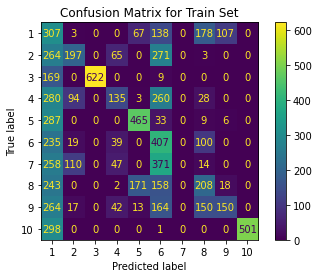

In [34]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

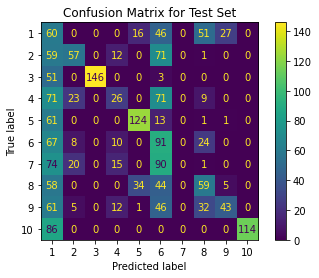

In [35]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()